In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchviz import make_dot

def sig(x):
    return 1/(1 + torch.exp(-x))

def tanh(x):
    return 2*sig(2*x) - 1

def dedt(E):
    # de = (-E + (1 - r*E)*sig(w_ee*E - w_ei*I + P)) / tau_E
    de = (-E + sig(k*E + k*P)) / tau_E
    return de


class Variable:
    def __init__(self, var_id, mu, sigma, left_dynamics_id, right_dynamics_id, obs_id):
        self.var_id = var_id
        self.mu = mu
        self.sigma = sigma
        self.eta = torch.zeros_like(mu, requires_grad=True)
        self.lmbda = torch.zeros_like(sigma, requires_grad=True)

        self.right_dynamics_id = right_dynamics_id
        self.left_dynamics_id = left_dynamics_id
        self.obs_id = obs_id

        self.factors = [self.obs_id, self.left_dynamics_id, self.right_dynamics_id]

        self.out_eta, self.out_lmbda = torch.zeros_like(mu), torch.zeros_like(sigma)

    def get_eta(self):
        return self.out_eta
    
    def get_mu(self):
        return self.mu
    
    def get_lmbda(self):
        return self.out_lmbda
    
    def get_sigma(self):
        return self.sigma

    def belief_update(self):
        eta_here, lmbda_here = torch.tensor([[0.]]), torch.tensor([[0.]])

        for fid in self.factors:
            if fid == -1: continue

            eta_here  += factor_nodes[fid].get_eta()
            lmbda_here += factor_nodes[fid].get_lmbda()

        if lmbda_here == 0.: print('We Hebben Een Serieus Probleem ')

        self.out_eta, self.out_lmbda = eta_here, lmbda_here

        self.sigma = torch.linalg.inv(self.out_lmbda)
        self.mu = self.sigma @ self.out_eta

    def compute_messages(self):
        self.belief_update()

        if self.right_dynamics_id == -1: return

        in_eta, in_lmbda = factor_nodes[self.right_dynamics_id].get_eta(), factor_nodes[self.right_dynamics_id].get_lmbda()

        self.out_eta -= in_eta 
        self.out_lmbda -= in_lmbda


class ObservationFactor:
    def __init__(self, f_id, var_id, z, lmbda_in):
        self.f_id = f_id
        self.z = z
        self.lmbda_in = lmbda_in
        self.var_id = var_id

        # Jacobian
        J = torch.tensor([[1.]])

        self.eta = (J.T @ lmbda_in) * z
        self.lmbda = (J.T @ lmbda_in) @ J
        self.N_sigma = torch.sqrt(lmbda_in[0,0])

        self.out_eta, self.out_lmbda = self.eta, self.lmbda
    
    def get_eta(self):
        return self.out_eta

    def get_lmbda(self):
        return self.out_lmbda
    
    def huber_scale(self):
        r = self.z - var_nodes[self.var_id].get_mu()
        M = torch.sqrt(r * self.lmbda_in[0,0] * r)

        if M > self.N_sigma:
            kR = (2 * self.N_sigma / M) - (self.N_sigma ** 2 / M ** 2)
            return kR
        
        return 1

    def compute_messages(self):
        kR = self.huber_scale()
        self.out_eta, self.out_lmbda = self.eta * kR, self.lmbda * kR

    def __str__(self):
        return f'Observation factor with connected to {self.var_id} and z = {self.z} '

class DynamicsFactor:
    ''' Et_id is the id of E_t, Etp_id is the id of E_{t+1}'''
    def __init__(self, f_id, lmbda_in, Et_id, Etp_id, beta = 0.):
        self.Et_id = Et_id
        self.Etp_id = Etp_id
        self.f_id = f_id
        self.lmbda_in = lmbda_in

        self.out_eta = torch.tensor([[0.0]])
        self.out_lmbda = torch.tensor([[0.0]])

        # Message damping
        self.prev_msg_right = None
        self.prev_msg_left = None
        self.beta = beta  # Damping constant

        self.N_sigma = torch.sqrt(lmbda_in[0,0])

        # self.update_eta_lmbda()
    
    def update_eta_lmbda(self):
        Et = var_nodes[self.Et_id].get_mu()[0,0].clone().detach().requires_grad_(True)
        Etp = var_nodes[self.Etp_id].get_mu()[0,0].clone().detach().requires_grad_(True)
        print(f'Using {Et} and {Etp} to calculate...')
        self.h = torch.abs(Etp - (Et + dedt(Et)))
        self.h.backward()

        J = torch.tensor([[Et.grad, Etp.grad]])
        print('h', self.h, J)

        x0 = torch.tensor([Et, Etp])
        self.eta = J.T @ self.lmbda_in * ((J @ x0) - self.h) 
        self.lmbdap = (J.T @ self.lmbda_in) @ J

        print(self.eta.shape, self.lmbdap.shape)

    def get_eta(self): 
        return self.out_eta

    def get_lmbda(self):
        return self.out_lmbda
    
    def huber_scale(self):
        r = 0 - (self.h)
        M = torch.sqrt(r * self.lmbda_in[0,0] * r)

        if M > self.N_sigma:
            k_r = (2 * self.N_sigma / M) - (self.N_sigma ** 2 / M ** 2)
            return k_r
        
        return 1

    def _compute_message_going_left(self):
        self.update_eta_lmbda()

        in_eta, in_lmbda = var_nodes[self.Etp_id].get_eta(), var_nodes[self.Etp_id].get_lmbda()
        k_r = self.huber_scale()

        # Compute the eta and lambda by var-factor rule and then scale
        eta_here, lambda_here = torch.clone(self.eta), torch.clone(self.lmbdap)

        eta_here[1] = self.eta[1] + in_eta
        lambda_here[1,1] = self.lmbdap[1,1] + in_lmbda

        eta_here *= k_r
        lambda_here *= k_r

        eta_a = eta_here[0]
        eta_b = eta_here[1]
        lambda_aa = lambda_here[0][0]
        lambda_ab = lambda_here[0][1]
        lambda_ba = lambda_here[1][0]
        lambda_bb = lambda_here[1][1]

        # Eq. 2.60 and 2.61 in Ortiz. 2003
        lambda_ab_lambda_bbinv = lambda_ab / lambda_bb
        out_eta = torch.tensor([eta_a - (lambda_ab_lambda_bbinv * eta_b)])
        out_lmbda = torch.tensor([lambda_aa - (lambda_ab_lambda_bbinv * lambda_ba)]) 

        print(out_eta, out_lmbda, self.beta)

        if self.prev_msg_left is not None:
            out_eta = self.beta * out_eta + (1 - self.beta) * self.prev_msg_left[0]
            out_lmbda = self.beta * out_lmbda + (1 - self.beta) * self.prev_msg_left[1]

        self.out_lmbda = out_lmbda
        self.out_eta = out_eta

    def compute_messages(self):
        self._compute_message_going_left()

    def __str__(self):
        return f'Dynamics Factor {self.f_id} connecting {self.Et_id} to {self.Etp_id} with eta = {self.out_eta} and lambda = {self.out_lmbda}'

def print_fg(vars, factors):
    for i, j in zip(vars, factors):
        print(vars[i])
        print(factors[j])

def update_observational_factor(key):
    if not isinstance(key, tuple):
        factor_nodes[key].compute_messages()

def update_variable_belief(key):
    var_nodes[key].compute_messages()

def update_dynamics_factor(key):
    if isinstance(key, tuple):
        factor_nodes[key].compute_messages()

In [ ]:
var_nodes, factor_nodes = {}, {}

sigma_smoothness = 1.
sigma_obs = 0.3

signal = [0.2, 0.8, 1.0, 1.0, 1.0]

r = .2
tau_E = 1.
P = .2
k = 5.

t = [1,2,3,4,5]

E0 = 0.

for i in range(len(t)):
    var_nodes[i] = Variable(i, torch.tensor([[E0]], requires_grad=True), torch.tensor([[0.0]], requires_grad=True), -1 if i == 0 else (i-1, i), -1 if i+1 == len(t) else (i, i+1), i)
    factor_nodes[i] = ObservationFactor(i, i, signal[i], torch.tensor([[sigma_obs ** -2]]))

for i in range(len(t)):
    if i+1 < len(t):
        factor_nodes[(i, i+1)] = DynamicsFactor((i, i+1), torch.tensor([[sigma_smoothness ** -2]]), i, i+1, 1.)

for i in range(25):
    print(f'-------- ITERATION {i} ----------')
    update_observational_factor(0)
    update_observational_factor(1)
    update_observational_factor(2)
    update_variable_belief(0)
    update_variable_belief(1)
    update_variable_belief(2)
    print('here', var_nodes[0].get_eta(), var_nodes[0].get_lmbda(), var_nodes[0].get_mu())
    print('here', var_nodes[1].get_eta(), var_nodes[1].get_lmbda(), var_nodes[1].get_mu())
    print('here', var_nodes[2].get_eta(), var_nodes[2].get_lmbda(), var_nodes[2].get_mu())
    update_dynamics_factor((0,1))
    update_dynamics_factor((1,2))
    print(factor_nodes[(0,1)].get_eta(), factor_nodes[(0,1)].get_lmbda())
    print(factor_nodes[(1,2)].get_eta(), factor_nodes[(1,2)].get_lmbda())

Iteration 0, k = (tensor([[1.]]), tensor([[2.]]))
Iteration 1, k = (tensor([[0.6569]], grad_fn=<MmBackward0>), tensor([[-0.1224]]))
Iteration 2, k = (tensor([[0.8286]], grad_fn=<MmBackward0>), tensor([[-0.9571]]))
Iteration 3, k = (tensor([[0.7285]], grad_fn=<MmBackward0>), tensor([[0.0790]]))
Iteration 4, k = (tensor([[0.9484]], grad_fn=<MmBackward0>), tensor([[-0.3668]]))
Iteration 5, k = (tensor([[5.4124]], grad_fn=<MmBackward0>), tensor([[-18.4488]]))
Iteration 6, k = (tensor([[0.5481]], grad_fn=<MmBackward0>), tensor([[1.1571]]))
Iteration 7, k = (tensor([[0.0450]], grad_fn=<MmBackward0>), tensor([[5.2005]]))
Iteration 8, k = (tensor([[0.7235]], grad_fn=<MmBackward0>), tensor([[-0.7001]]))
Iteration 9, k = (tensor([[0.4346]], grad_fn=<MmBackward0>), tensor([[0.7735]]))
Iteration 10, k = (tensor([[0.4695]], grad_fn=<MmBackward0>), tensor([[0.4857]]))
Iteration 11, k = (tensor([[0.6399]], grad_fn=<MmBackward0>), tensor([[0.2072]]))
Iteration 12, k = (tensor([[0.6487]], grad_fn=<MmBa

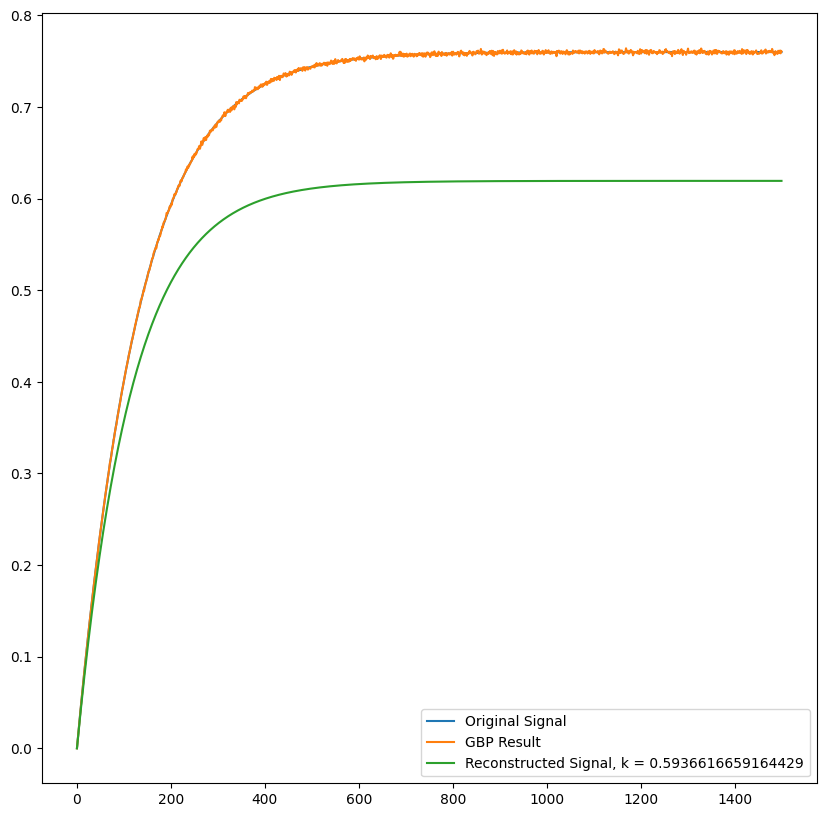

In [3]:
from fg.variables import Variable, Parameter
from fg.factors import DynamicsFactor, ObservationFactor
from fg.simulation_config import simulate_signal
from fg.graph import Graph
from fg.gaussian import Gaussian
import torch
import matplotlib.pyplot as plt


if __name__ == "__main__":
    sigma_obs = 1e-1
    sigma_dynamics = 1e-3
    GT_k = 1.2
    T, dt = 15, 0.01
    iters = 20

    signal = simulate_signal(T, dt, GT_k)
    # signal = [1., 2., 3., 4.]
    t = torch.arange(0, len(signal), 1)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    factor_graph = Graph()

    param_dict = {
        'k': Parameter(len(t), Gaussian(torch.tensor([[1.0]]), torch.tensor([[2.]])), factor_graph, [])
    }

    # -- Construct FG -- #
    # Add our variable and observation factors at each time step
    for i in range(len(t)):
        factor_graph.var_nodes[i] = Variable(i, Gaussian(torch.tensor([[0.]]), torch.tensor([[0.2]])), -1 if i == 0 else (i-1, i), -1 if i+1 == len(t) else (i,i+1), i, factor_graph)
        factor_graph.factor_nodes[i] = ObservationFactor(i, i, signal[i], torch.tensor([[sigma_obs ** -2]]), factor_graph)

    # Add our parmaters as additional variables to our factor graph
    for _,p in param_dict.items():
        factor_graph.param_ids.append(p.id)
        factor_graph.var_nodes[p.id] = p

    # Connect dynamics factors between timestep i and i+1 and connect each dyn. factor to our parameters
    for i in range(len(t)):
        if i+1 < len(t):
            dyn_id = (i, i+1)
            factor_graph.factor_nodes[dyn_id] = DynamicsFactor(i, i+1, torch.tensor([[sigma_dynamics ** -2]]), dyn_id, factor_graph)

            for _,p in param_dict.items():
                p.connected_factors.append(dyn_id)


    # == RUN GBP (Sweep schedule) === #
    for iter in range(iters):
        print(f'Iteration {iter}, k = {param_dict["k"].mean, param_dict["k"].cov}')
        if iter == 0:
            factor_graph.send_initial_parameter_messages()
            factor_graph.update_all_observational_factors()

        # -- RIGHT PASS --
        for i in range(len(t)-1):
            curr = factor_graph.var_nodes[i]

            curr.compute_and_send_messages()

            fac = factor_graph.factor_nodes[curr.right_id]

            fac.compute_messages_except_key()

        factor_graph.update_params()

        # -- LEFT PASS --
        for i in range(len(t)-1, 0, -1):
            curr = factor_graph.var_nodes[i]

            curr.compute_and_send_messages()

            fac = factor_graph.factor_nodes[curr.left_id]

            fac.compute_messages_except_key()

        factor_graph.update_params()


    # Plotting results
    ax.plot(signal, label='Original Signal')
    recons_signal = torch.tensor([v.mean for k, v in factor_graph.var_nodes.items() if k not in factor_graph.param_ids])

    ax.plot(recons_signal, label='GBP Result')

    ax.plot(simulate_signal(T, dt, param_dict["k"].mean.item()), label=f'Reconstructed Signal, k = {param_dict["k"].mean.item()}')
    plt.legend()
    plt.show()

# factor_graph.send_initial_parameter_messages()
# factor_graph.update_all_observational_factors()

# i = 0
# curr = factor_graph.var_nodes[i]
# curr.compute_and_send_messages()
# fac = factor_graph.factor_nodes[curr.right_id]
# fac.compute_messages_except_key()

# i = 1
# curr = factor_graph.var_nodes[i]
# curr.compute_and_send_messages()
# fac = factor_graph.factor_nodes[curr.right_id]
# fac.compute_messages_except_key()

# # i = 2
# curr = factor_graph.var_nodes[i]
# curr.compute_and_send_messages()
# fac = factor_graph.factor_nodes[curr.right_id]
# fac.compute_messages_except_key()


In [ ]:
for _, v in factor_graph.var_nodes.items():
    print(v, v.inbox)

for _, v in factor_graph.factor_nodes.items():
    print(v.factor_id, v.inbox)


In [ ]:
g1 = Gaussian(torch.tensor([[1.]]), torch.tensor([[2.]]))
g2 = Gaussian.zeros_like(g1)
print(g1 ,g2)
g3 = g1 * 0.8 * (g2 * 0.2)
print(g3)